In [1]:
import networkx as nx
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

import numpy as np
import pandas as pd
from collections import Counter

from math import comb

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

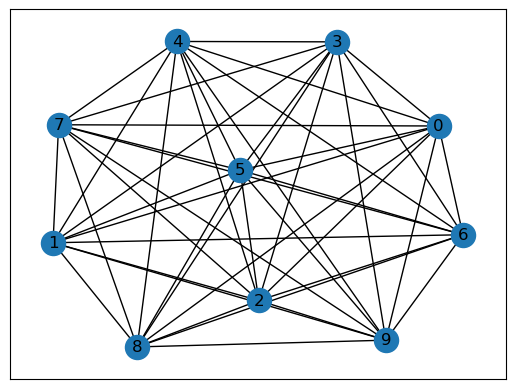

In [247]:
n_propositions = 10
knowledge_graph = nx.complete_graph(n_propositions)

edges = np.array([*knowledge_graph.edges()])
n_edges = len(edges)

nx.draw_networkx(knowledge_graph)

# **Scenario 1: Knowledge Graph Without Subjectivity**
Agents' belief networks do not have signs. Everybody has the same knowledge once they have it.

### Intialize the Agents

In [165]:
n_edges_per_agent = 3
n_agent = 50

agent_belief_networks = {}

for i in range(n_agent):
    chosen_edges = edges[np.random.choice([*range(n_edges)], n_edges_per_agent, replace=False)]
    agent_belief_networks[i] = chosen_edges
    
agents_list = [*agent_belief_networks.keys()]

### Simulate

In [182]:
sim_steps = 100000

for t in range(sim_steps):
    S, R = np.random.choice(agents_list, 2, replace=False)
    intersection = np.intersect1d(agent_belief_networks[S].flatten(), agent_belief_networks[R].flatten())
    if len(intersection)>0:
        #print('S:',agent_belief_networks[S],'\nR:',agent_belief_networks[R])
        chosen_knowledge = np.random.choice(intersection)
        #print('Intersection:', intersection,'\nChosen knowledge:',chosen_knowledge,'\n')
        
        # detect where the chosen knowledge is
        row = np.where(agent_belief_networks[S]==chosen_knowledge)[0][0]
        
        # add it to receiver's belief network
        agent_belief_networks[R] = np.concatenate([agent_belief_networks[R], [agent_belief_networks[S][row]]])
        #print(agent_belief_networks[R])

### Results
Agents do not get polarized, if the simulation runs as much as possible, everybody gets the same belief network.

# **Scenario 2: Signed Belief Networks**
Like Ising Model, both nodes and edges have signs. For a receiver (R) to accept something: (1) has at least one mutual node with the sender (S), (2) the new edge and node that S is sending should be consonant with R's belief system.

### The knowledge graph
Entire knowledge in the universe is kept in this knowledge graph

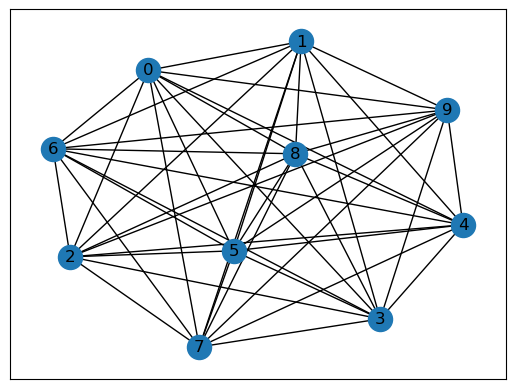

In [22]:
n_propositions = 10
knowledge_graph = nx.complete_graph(n_propositions)

edges = np.array([*knowledge_graph.edges()])
n_edges = len(edges)

nx.draw_networkx(knowledge_graph)

### Initialize the agents

In [4]:
def internal_hamiltonian(g):

    # initialize the Hamiltonian energy
    H = 0
    
    # add each edge's influence
    for e in g.edges():
        H += g.nodes[e[0]]['weight']*g.nodes[e[1]]['weight']*g.edges[e]['weight']

    # normalize to [-1,+1]
    H = - H/len(g.edges())
    
    return H

In [8]:
def social_hamiltonian(R, g, agent_belief_networks):

    H_social = 0

    for a, b in agent_belief_networks.items():
        if a != R:
            iou = len(set(g.edges).intersection(set(b.edges))) / len(set(g.edges).union(set(b.edges)))
            H_social += iou
            
    H_social = H_social / (len(agent_belief_networks) - 1)
    
    return H_social

In [154]:
n_edges_per_agent = 2
n_agent = 100

agent_belief_networks = {}

for i in range(n_agent):
    
    # choose edges randomly
    chosen_edges = edges[np.random.choice([*range(n_edges-1)], n_edges_per_agent, replace=False)]
    
    # add one common sensical edge
    chosen_edges = np.concatenate([chosen_edges, [edges[-1]]])
    
    # initialize agent's belief network
    g = nx.Graph()
    
    for e in chosen_edges:
        
        # determine signs
        s = [np.random.choice([-1,1]) for i in range(3)]
        
        # add edge with its respective sign
        g.add_edge(e[0], e[1], weight = s[1])
        
        # set node signs
        nx.set_node_attributes(g, {e[0]:{'weight':s[0]}, e[1]:{'weight':s[2]}})
    
    # save edges in agent's dict
    agent_belief_networks[i] = g
    
agents_list = [*agent_belief_networks.keys()]

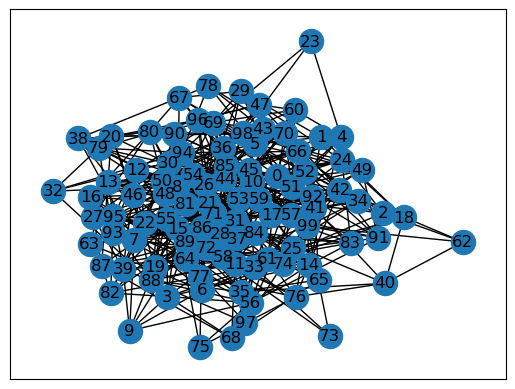

In [155]:
connected = False
while not connected:
    G = nx.erdos_renyi_graph(n=n_agent, p=.1)
    connected = nx.is_connected(G)
    
nx.draw_networkx(G)

In [156]:
p_political = .7
sim_steps = 10000

for t in tqdm(range(sim_steps)):
    S = np.random.choice(agents_list, 1)[0]
    R = np.random.choice([*G.neighbors(S)], 1)[0]
    intersection = set([*agent_belief_networks[S].nodes()]).intersection(set([*agent_belief_networks[R].nodes()]))
    
    #if len(intersection)>0:
    
    # biased information exchange
    #p_rest = (1 - p_political)/(len(intersection) - 1)
    #p = (len(intersection)-1)*[p_rest] + [p_political]
    
    # choose one node with defined probabilities
    chosen_node = np.random.choice(list(intersection))
    
    S_edges = np.array([*agent_belief_networks[S].edges()])
    R_edges = np.array([*agent_belief_networks[R].edges()])
    
    chosen_edge_idx_to_send = np.random.choice(np.where(S_edges==chosen_node)[0])
    chosen_edge = S_edges[chosen_edge_idx_to_send]
    
    # compute the Hamiltonian of R
    H_internal = internal_hamiltonian(agent_belief_networks[R])
    H_social = social_hamiltonian(R, agent_belief_networks[R], agent_belief_networks)
    H = (H_internal + H_social)/2
    
    # create a new belief network for R
    R_new = agent_belief_networks[R].copy()
    
    # if chosen edge is already in R's belief network:
    if agent_belief_networks[R].has_edge(chosen_edge[0], chosen_edge[1]):
    
        R_new.edges[chosen_edge]['weight'] = agent_belief_networks[S].edges[chosen_edge]['weight']
        R_new.nodes[chosen_edge[0]]['weight'] = agent_belief_networks[S].nodes[chosen_edge[0]]['weight']
        R_new.nodes[chosen_edge[1]]['weight'] = agent_belief_networks[S].nodes[chosen_edge[1]]['weight']
    
    # if chosen edge is not in R's belief network:
    else:
        for i in [0,1]:
            if chosen_edge[i] in R_new.nodes():
                R_new.nodes[chosen_edge[i]]['weight'] = agent_belief_networks[S].nodes[chosen_edge[i]]['weight']
            else:
                R_new.add_node(chosen_edge[i], weight = agent_belief_networks[S].nodes[chosen_edge[i]]['weight'])
        
        R_new.add_edge(chosen_edge[0], chosen_edge[1], weight = agent_belief_networks[S].edges[chosen_edge]['weight'])
    
    # compute the Hamiltonian for the new belief network
    H_internal_new = internal_hamiltonian(R_new)
    H_social_new = social_hamiltonian(R, R_new, agent_belief_networks)
    H_new = (H_internal_new + H_social_new)/2
    
    # if the new network yields a better (lower) Hamiltonian, replace the belief network
    if H_new <= H:
        agent_belief_networks[R] = R_new

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 293.09it/s]


In [157]:
belief_similarities = []

for a1,b1 in agent_belief_networks.items():
    _ = []
    for a2,b2 in agent_belief_networks.items():
        iou = len(set(b1.edges).intersection(set(b2.edges))) / len(set(b1.edges).union(set(b2.edges)))
        _.append(iou)
    belief_similarities.append(_)
    
belief_similarities = np.array(belief_similarities)

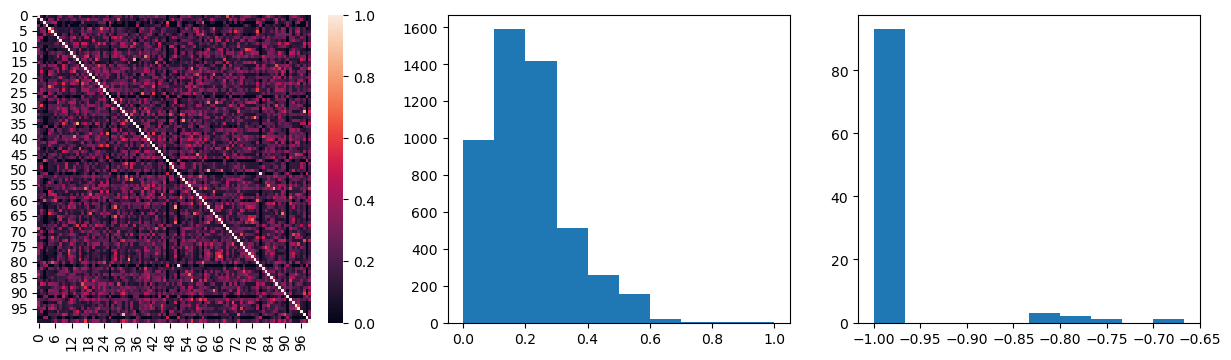

In [158]:
belief_distances = 1 - belief_similarities

fig, axs = plt.subplots(1,3,figsize=(15,4))
sns.heatmap(belief_similarities,ax=axs[0])
axs[1].hist(belief_similarities[np.triu_indices_from(belief_similarities, k=1)])
axs[2].hist([internal_hamiltonian(v) for v in agent_belief_networks.values()])

plt.show()

In [159]:
clustering = DBSCAN(eps=.4, metric='precomputed', min_samples=5).fit(belief_distances)
clustering.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [160]:
Counter(clustering.labels_)

Counter({-1: 100})

In [162]:
[*G.neighbors(5)]

[1, 12, 17, 31, 42, 45, 48, 49, 67, 69, 78, 81, 92, 96]

In [168]:
np.mean([nx.centrality.eigenvector.eigenvector_centrality(agent_belief_networks[i])[9] for i in range(46)])

0.21574586276662158

In [169]:
np.mean([np.mean([v for k,v in nx.betweenness_centrality(agent_belief_networks[i]).items() if k!=9]) for i in range(46)])

0.17276769282592266

In [ ]:
np.mean([nx.betweenness_centrality(agent_belief_networks[i])[9] for i in range(46)])

# **Scenario 3: The Role of Information Sequence**

### The knowledge graph

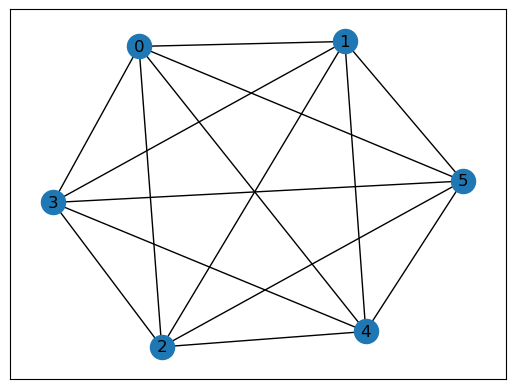

In [173]:
n_propositions = 6
knowledge_graph = nx.complete_graph(n_propositions)

edges = np.array([*knowledge_graph.edges()])
n_edges = len(edges)

nx.draw_networkx(knowledge_graph)

In [105]:
comb(10,2)

45

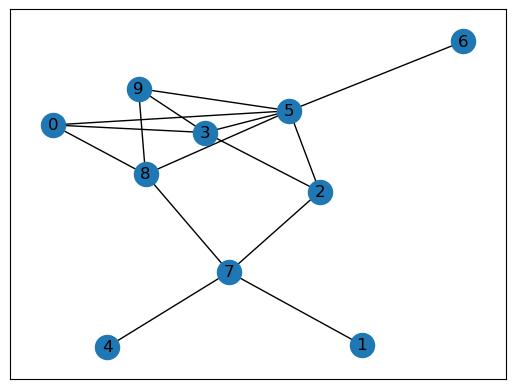

In [104]:
n_propositions = 10
n_edges = 15

connected = False
while not connected:
    g = nx.gnm_random_graph(n=n_propositions, m=n_edges)
    connected = nx.is_connected(g)
    
nx.draw_networkx(g)